In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from skimage.measure import label, regionprops
import builtins

# **Chargement et Mapping des fichiers**

In [2]:
# --- 1. Configuration 
# Path to data set 
base_dir = "/kaggle/input/skin-cancer-mnist-ham10000"
metadata_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

# --- 2. Chargement des donner 
print("Reading CSV file") 
df = pd.read_csv(metadata_path)

# --- 3. Image mapping 
# Dictionnaire {image_id : full_path}
image_path_dict = {}

print("Images mapping ...")
for dirname , _ , filenames, in os.walk(base_dir) : 
    for filename in filenames : 
        if(filename.endswith('.jpg')) : 
            image_id = filename.replace('.jpg' , '')
            image_path_dict[image_id] = os.path.join(dirname , filename)


# add path colone to the dataframe(df) 
df['path'] = df['image_id'].map(image_path_dict)

# --- 4. Readable Dict for lesion types 
lesion_type_dict = {
    'nv': 'Melanocytic nevi (Grain de beauté)',
    'mel': 'Melanoma (Cancer)',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict)

# brief verification of the dataset

print(f"\nDataset chargé ! Total : {df.shape[0]} lignes.")
df.head()

Reading CSV file
Images mapping ...

Dataset chargé ! Total : 10015 lignes.


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis


# **ANALYSE DE LA DISTRIBUTION**


Repartition des classes : 
cell_type
Melanocytic nevi (Grain de beauté)    6705
Melanoma (Cancer)                     1113
Benign keratosis                      1099
Basal cell carcinoma                   514
Actinic keratoses                      327
Vascular lesions                       142
Dermatofibroma                         115
Name: count, dtype: int64


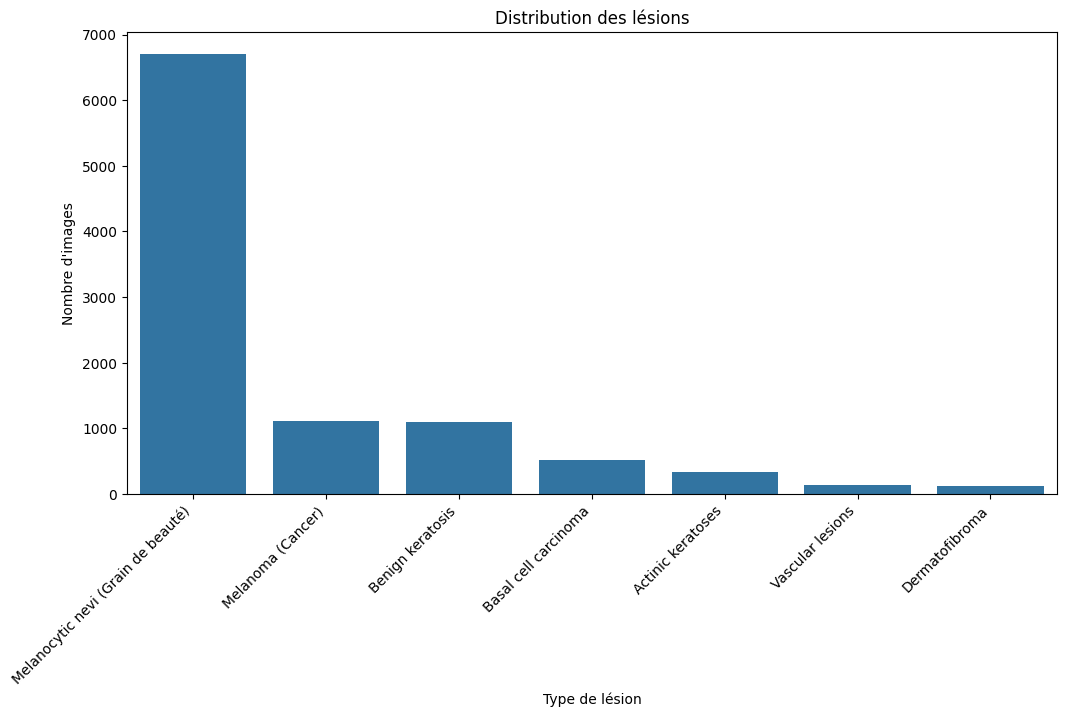


Proportion de Mélanomes (Cancer) : 1113 / 10015 soit 11.11%


In [3]:
# --- 1. Calcule des chifres exactes 
print("\nRepartition des classes : ")
print(df['cell_type'].value_counts())

# --- 2. Graphique (Histogrames)
plt.figure(figsize=(12, 6))
sns.countplot(x='cell_type', data=df, order=df['cell_type'].value_counts().index)
plt.title('Distribution des lésions')
plt.xlabel('Type de lésion')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45, ha='right')
plt.show()

# --- 3. La melanoma (Cancer) proportion
nb_mel = df[df['dx'] == 'mel'].shape[0]
nb_total = df.shape[0]
print(f"\nProportion de Mélanomes (Cancer) : {nb_mel} / {nb_total} soit {nb_mel/nb_total:.2%}")


# **Images**

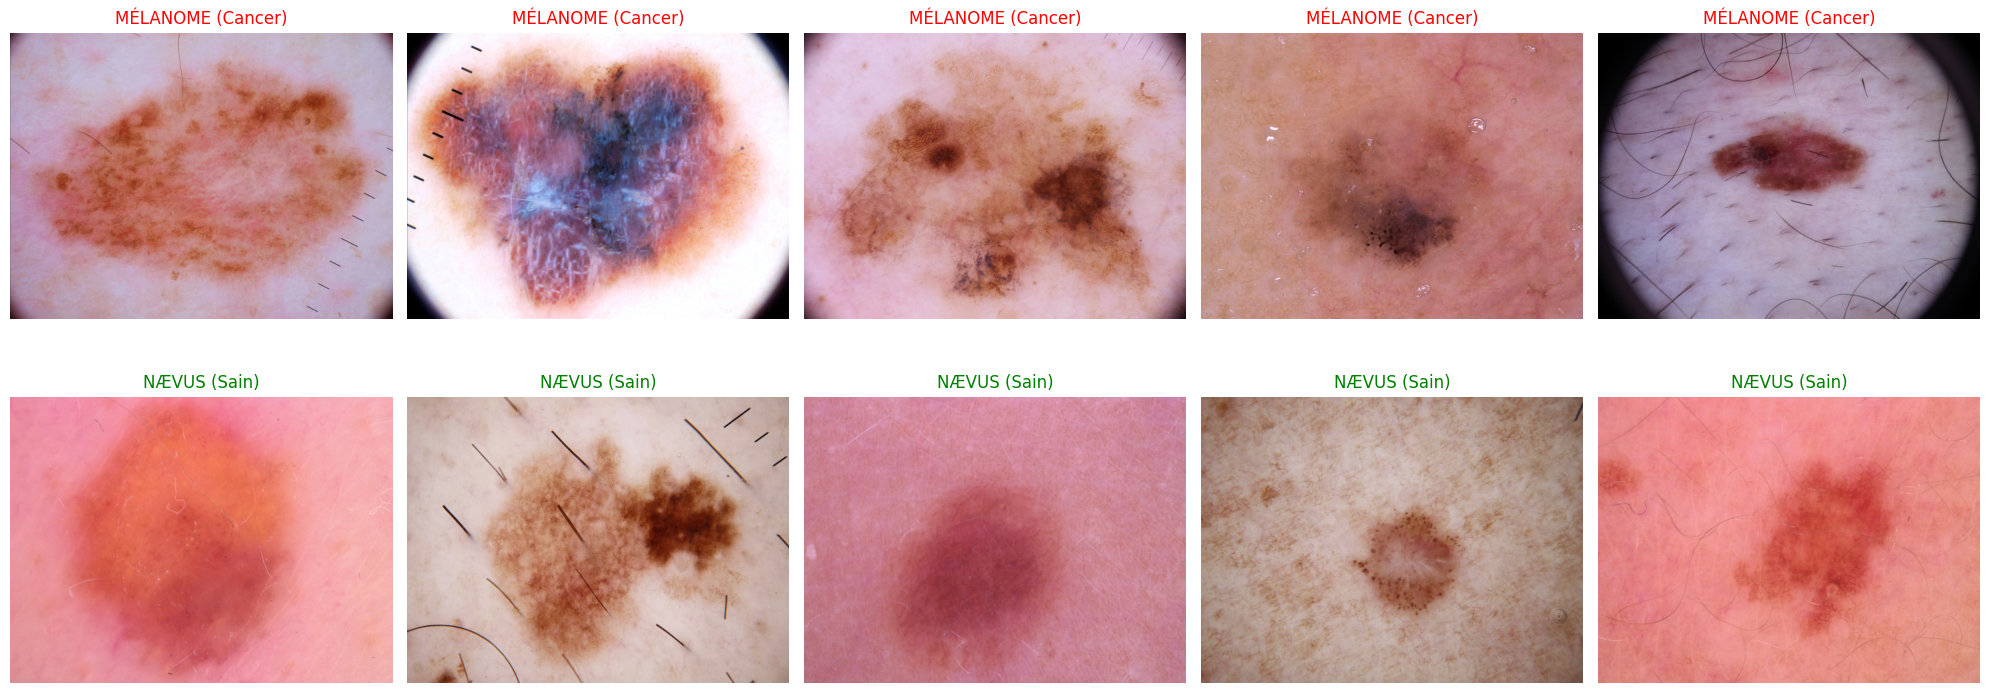

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# On configure la taille de l'affichage
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) # 2 lignes, 5 colonnes

# --- LIGNE 1 : LES MÉLANOMES (Cancers) ---
# On prend 5 images au hasard qui sont des mélanomes ('mel')
melanoma_samples = df[df['dx'] == 'mel'].sample(5, random_state=42)

for i, (index, row) in enumerate(melanoma_samples.iterrows()):
    img = Image.open(row['path']) # On ouvre l'image grâce au chemin
    axes[0, i].imshow(img)
    axes[0, i].set_title("MÉLANOME (Cancer)", color='red', fontsize=12)
    axes[0, i].axis('off') # On cache les axes X/Y

# --- LIGNE 2 : LES NÆVUS (Grains de beauté sains) ---
# On prend 5 images au hasard qui sont des nævus ('nv')
nevus_samples = df[df['dx'] == 'nv'].sample(5, random_state=42)

for i, (index, row) in enumerate(nevus_samples.iterrows()):
    img = Image.open(row['path'])
    axes[1, i].imshow(img)
    axes[1, i].set_title("NÆVUS (Sain)", color='green', fontsize=12)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# **Creating test set (Stratified)**

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# --- 1. Configurer le split ( 20% test , 80% train)
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2 , random_state = 42 )

# --- 2. Excutuion de split 
# Application de split sur la colonne dx ( typde de maladie)
for train_index , test_index in split.split(df , df['dx']) : 
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# --- 3. Verification mathematique 
def afficher_proportions(data , nom) : 
    props = data['dx'].value_counts() / len(data)
    print(f"\n--- {nom} ---")
     # Affiche les 3 principales classes (nv, mel, bkl)

    print(props.head(3))
afficher_proportions(df, "Dataset Complet (Original)")
afficher_proportions(strat_test_set, "Test Set (Votre coffre-fort)")

print(f"\nNombre d'images d'entraînement : {len(strat_train_set)}")
print(f"Nombre d'images de test : {len(strat_test_set)}")



--- Dataset Complet (Original) ---
dx
nv     0.669496
mel    0.111133
bkl    0.109735
Name: count, dtype: float64

--- Test Set (Votre coffre-fort) ---
dx
nv     0.669496
mel    0.111333
bkl    0.109835
Name: count, dtype: float64

Nombre d'images d'entraînement : 8012
Nombre d'images de test : 2003


# **Undersampling the data**

In [6]:
 from sklearn.utils import resample 

# --- 1. Class separation 
mel_df = strat_train_set[strat_train_set['dx'] == 'mel']
nv_df = strat_train_set[strat_train_set['dx'] == 'nv']

# --- 2. Undersampling 
nv_downsampled = resample(nv_df ,
                           replace = False ,
                           n_samples = len(mel_df) ,
                           random_state = 42 ) 

# --- 3. Fusion 
train_balanced = pd.concat([mel_df , nv_downsampled])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 4. Verificatin
# ignore all what we did  : 
train_balanced = strat_train_set
print(f"Taille finale : {len(train_balanced)}")
print(train_balanced['dx'].value_counts())

Taille finale : 8012
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64


# **Prétraitement d’Images**

In [7]:
def augment_image(img):
    """
    Renvoie une liste de 3 versions de l'image :
    1. Originale
    2. Rotation 90° (Comme dans le papier short1)
    3. Flip Horizontal (Miroir)
    """
    images = []
    
    # 1. Originale
    images.append(img)
    
    # 2. Rotation 90°
    img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    images.append(img_90)
    
    # 3. Flip Horizontal
    img_flip = cv2.flip(img, 1)
    images.append(img_flip)
    
    return images

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_paper_strict(image_path):
    # 1. Lecture
    img = cv2.imread(image_path)
    if img is None: return None
    
    # 2. Resize (Standardisation obligatoire)
    img = cv2.resize(img, (224, 224))
    
    # --- MÉTHODE EXACTE DU PAPIER (Section 3.2.1) ---
    
    # A. Conversion en gris
    grayScale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # B. BlackHat Transform
    # "structuring element k of size 5x5" [Source: 209]
    # Cela permet de ne capturer que les structures très fines (poils)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # C. Création du Masque (Seuillage)
    # "Binary Threshold (T=15)" [Source: 222]
    # On ne garde que les pixels très sombres détectés par le blackhat
    _, mask = cv2.threshold(blackhat, 15, 255, cv2.THRESH_BINARY)
    
    # D. Inpainting (Réparation)
    # "masking radius value of 3" [Source: 215]
    # Un rayon petit (3) évite de créer des zones floues (softness)
    dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    
    return dst, mask # Je renvoie aussi le masque pour qu'on puisse vérifier ce qu'il a détecté



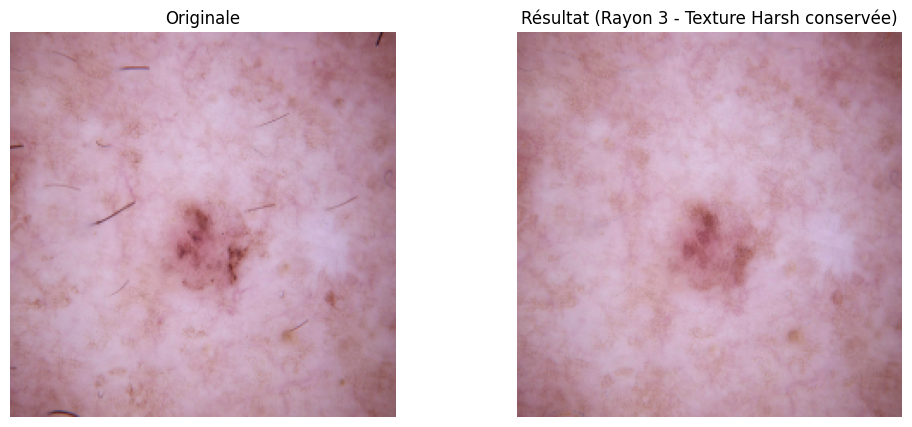

In [9]:
# --- TEST DE VÉRIFICATION SUR UNE IMAGE ---
# On reprend une image au hasard pour comparer
random_row = train_balanced.sample(1).iloc[0]
img_path = random_row['path']

original = cv2.resize(cv2.imread(img_path), (224, 224))
processed, debug_mask = preprocess_paper_strict(img_path)

plt.figure(figsize=(12, 5))

# 1. L'originale
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Originale")
plt.axis('off')


# 3. Le Résultat final
plt.subplot(1, 2,2)
plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
plt.title("Résultat (Rayon 3 - Texture Harsh conservée)")
plt.axis('off')

plt.show()

# **GLCM Extraction**

In [10]:
def extract_glcm_features(img) : 
    """
        Extract glcm features
        Args : 
            img (numpy array) : Clean RGB image 
        Returns : 
            numpy array : Features vector (5 values )
    """
    # --- 1. Grayscale transformation 
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    else :
        gray = img 

    # --- 2. Calculate glcm matrix 
    # distance = 1 , we see the neighbor pixel 
    # angles : We check 4 angels ( 0° , 45° , 90° , 135°)
    # symmetric = True , normed = True : Standard
    glcm = graycomatrix(gray ,
                        distances = [1] , 
                        angles = [0 , np.pi/4 , np.pi / 2 , np.pi , 3*np.pi/4] ,
                        levels = 256 , symmetric = True , normed = True ) 

    # --- 3. Propreties extraction  
    contrast = graycoprops(glcm , 'contrast').mean()
    dissimilarity = graycoprops(glcm , 'dissimilarity').mean()
    homogeneity = graycoprops(glcm , 'homogeneity').mean()
    energy = graycoprops(glcm , 'energy').mean()
    correlation = graycoprops(glcm , 'correlation').mean()

    return np.array([contrast, dissimilarity, homogeneity, energy, correlation ])


In [11]:
# --- TEST UNITAIRE IMMÉDIAT ---
# On charge une image, on la nettoie, et on teste le module GLCM seul.

# 1. Charger une image au hasard
random_row = train_balanced.sample(1).iloc[0]
img_path = random_row['path']
print(f"Test sur l'image : {img_path}")

# 2. Préparer l'image (Nettoyage "Papier Strict" qu'on a validé avant)
img_clean, _ = preprocess_paper_strict(img_path)

# 3. Extraire le GLCM
glcm_vector = extract_glcm_features(img_clean)

# 4. Résultats
print("\n--- Résultats GLCM ---")
print(f"Vecteur de sortie (Shape) : {glcm_vector.shape}")
print(f"Contraste     : {glcm_vector[0]:.4f} (Rugosité)")
print(f"Dissimilarité : {glcm_vector[1]:.4f} (Différence moyenne)")
print(f"Homogénéité   : {glcm_vector[2]:.4f} (Douceur)")
print(f"Énergie       : {glcm_vector[3]:.4f} (Uniformité)")
print(f"Corrélation   : {glcm_vector[4]:.4f} (Motifs linéaires)")

Test sur l'image : /kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028651.jpg

--- Résultats GLCM ---
Vecteur de sortie (Shape) : (5,)
Contraste     : 22.0110 (Rugosité)
Dissimilarité : 3.6267 (Différence moyenne)
Homogénéité   : 0.2402 (Douceur)
Énergie       : 0.0336 (Uniformité)
Corrélation   : 0.9723 (Motifs linéaires)


# **Colour variegation**
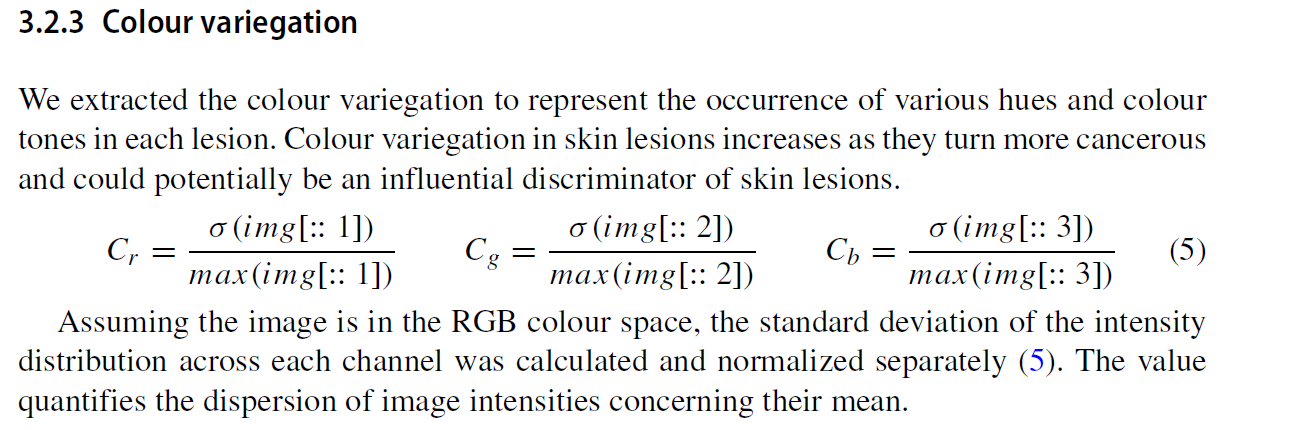

In [12]:
def extract_color_variegation(img) : 
    """
        Extract the color varigation ,based on :
        ( Detecting skin lesions fusing handcrafted features in image network ensembles ) paper 
        Args:
            image (numpy array): Image BGR (déjà nettoyée).
        Returns:
            numpy array: Vecteur de 3 valeurs [Cr, Cg, Cb].
        
    """

    # --- 1. BRG convertion to RGB 
    if len(img.shape) == 3  : 
        img_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    else : 
        return None

    # --- 2. Channels separation 
    R = img_rgb[:, :, 0]
    G = img_rgb[:, :, 1]
    B = img_rgb[:, :, 2]

    # --- 3. Calculations based on the paper formula 
    Cr = np.std(R) / np.max(R)
    Cg = np.std(G) / np.max(G)
    Cb = np.std(B) / np.max(B)

    return np.array([Cr , Cg , Cb])

    
        

In [13]:
# --- TEST UNITAIRE ---
# On reprend notre image de test habituelle
random_row = train_balanced.sample(1).iloc[0]
img_path = random_row['path']
img_clean, _ = preprocess_paper_strict(img_path)

color_feats = extract_color_variegation(img_clean)

print(f"Test sur l'image : {img_path}")
print("\n--- Résultats Colour Variegation ---")
print(f"Cr (Rouge) : {color_feats[0]:.4f}")
print(f"Cg (Vert)  : {color_feats[1]:.4f}")
print(f"Cb (Bleu)  : {color_feats[2]:.4f}")
print("Interprétation : Plus c'est haut, plus la couleur est 'désordonnée' (signe suspect).")

Test sur l'image : /kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029956.jpg

--- Résultats Colour Variegation ---
Cr (Rouge) : 0.0577
Cg (Vert)  : 0.1527
Cb (Bleu)  : 0.1774
Interprétation : Plus c'est haut, plus la couleur est 'désordonnée' (signe suspect).


# **LBP Extrarction**

In [14]:
def extract_lbp_features(img) : 
    """
    Extraction of LBP
        Args:
            image (numpy array): Image BGR (déjà nettoyée).
        Returns:
            numpy array: 256 value normalized Histogramme .
    """
    # --- 1. Grayscale transformation 
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    else :
        gray = img 

    # --- 2. Calculate LBP 
    # P = 8 (8 neighbors) , R=1(1 pixel ) -> 3x3 Stabdard 
    # methode = 'default' , to get all 256 values 
    lbp = local_binary_pattern(gray, P=8, R=1, method='default')

    # --- 3. Histogramme calculation 
    # bins = 256 
    # range ( 0 , 256 ) 
    (hist , _) = np.histogram(lbp.ravel() , bins = 256 , range = (0 , 256))

    # --- 4. Normalization  
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6) #1e-6 to avoid dividing by 0

    return hist  



In [15]:
# --- TEST UNITAIRE ---
random_row = train_balanced.sample(1).iloc[0]
img_path = random_row['path']
img_clean, _ = preprocess_paper_strict(img_path)

lbp_vector = extract_lbp_features(img_clean)

print(f"Test sur l'image : {img_path}")
print("\n--- Résultats LBP ---")
print(f"Taille du vecteur : {lbp_vector.shape} (Doit être 256)")
print(f"Premières valeurs : {lbp_vector[:10]}")
print("Interprétation : C'est une 'signature' complexe de la texture locale.")

Test sur l'image : /kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027832.jpg

--- Résultats LBP ---
Taille du vecteur : (256,) (Doit être 256)
Premières valeurs : [0.04916693 0.01472816 0.00167411 0.00603874 0.02395568 0.00376674
 0.00593909 0.01773756 0.00167411 0.00025909]
Interprétation : C'est une 'signature' complexe de la texture locale.


# **SEGMENTATION (OTSU)**

In [16]:
def get_segmentation_mask(img_clean) : 
    """
        Issolation des lesion de peau via la methode Otsu
        retourner un mask binaire ( 0 = Peau , 1 = Lesion )
    """

    # --- 1. Grayscale convertion 
    gray = cv2.cvtColor(img_clean , cv2.COLOR_BGR2GRAY)

    # --- 2. Thresholding using Otsu
    _ , mask = cv2.threshold(gray , 0 , 255 , cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    return mask

    

# **ABCD METHOD**

In [17]:
def extract_shape_features_safe(mask):
    # Version qui n'utilise PAS le mot-clé max()
    labeled_mask = label(mask > 0)
    regions = regionprops(labeled_mask)
    
    if not regions:
        return np.zeros(5) # Retourne des zéros si pas de lésion
    
    # Tri pour trouver la plus grande région sans utiliser max()
    regions.sort(key=lambda r: r.area, reverse=True)
    lesion = regions[0]
    
    area = lesion.area
    perimeter = lesion.perimeter
    if perimeter == 0: circularity = 0
    else: circularity = (4 * np.pi * area) / (perimeter ** 2)
    
    eccentricity = lesion.eccentricity
    solidity = lesion.solidity
    
    return np.array([area, perimeter, circularity, eccentricity, solidity])


def extract_masked_color(img_clean , mask) : 
    """
        Calculate the moy RGB color in the lesion , ignoring the skin 
    """
    mean_val = cv2.mean(img_clean , mask = mask)[:3]
    return np.array(mean_val)

# **ALL FEATURES COLLECTED IN ONE FUNC**

In [18]:
def extract_hybrid_features(image_path):
    """
    MODIFIÉE : Charge l'image, l'augmente (x3) et renvoie une LISTE de vecteurs.
    """
    # 1. Cleaning (On garde ta méthode stricte)
    # L'image est chargée ICI depuis le disque
    img, _ = preprocess_paper_strict(image_path)
    
    # Sécurité : Si l'image est illisible, on renvoie une liste vide
    if img is None: 
        return []

    # --- NOUVEAUTÉ : AUGMENTATION INTERNE ---
    # On génère les 3 versions (Originale, Tournée, Miroir)
    # Note : Assure-toi d'avoir défini la fonction 'augment_image' plus haut !
    images_to_process = augment_image(img)
    
    final_results = []

    # 2. On boucle sur les 3 versions de l'image
    for current_img in images_to_process:
        try:
            # A. Specialized calls (Sur l'image augmentée courante)
            glcm_vector = extract_glcm_features(current_img)
            color_vector = extract_color_variegation(current_img)
            
            # Tu peux commenter ça si tu veux vraiment supprimer LBP
            lbp_vector = extract_lbp_features(current_img) 

            # B. ABCD Features (Sur l'image augmentée courante)
            # On recalcule le masque pour la version tournée/inversée
            mask = get_segmentation_mask(current_img)
            
            shape = extract_shape_features_safe(mask)
            color_precise = extract_masked_color(current_img, mask)
            
            # C. Fusion
            # [5] + [3] + [256] + [5] + [3]
            final_vector = np.concatenate([glcm_vector, color_vector,  shape, color_precise])
            
            final_results.append(final_vector)
            
        except Exception as e:
            # Si une augmentation plante (rare), on l'ignore et on passe à la suivante
            continue

    # On renvoie une LISTE de 3 vecteurs (ou moins si erreur)
    return final_results

In [19]:
# --- LA GRANDE BOUCLE (EXTRACTION HYBRIDE + AUGMENTATION) ---
print(f"🚀 Démarrage de l'Extraction HYBRIDE BOOSTÉE sur {len(train_balanced)} images...")
print("⏳ L'augmentation x3 est activée (Original + Rotation + Flip)...")

X_train = []
y_train = []

# Compteur d'erreurs éventuelles
errors = 0

for index, row in train_balanced.iterrows():
    # Barre de progression simple
    if index % 100 == 0:
        print(f"   -> Traitement image {index} / {len(train_balanced)}")
        
    try:
        # 1. Appel de la fonction modifiée (Elle renvoie maintenant une LISTE !)
        feats_list = extract_hybrid_features(row['path'])
        
        # 2. Si la liste n'est pas vide (l'extraction a réussi)
        if feats_list:
            
            # On définit le label une seule fois pour cette image (Cancer ou Bénin)
            target = 1 if row['dx'] == 'mel' else 0

            # 3. ON DÉBALLE LA LISTE (Original + Augmentations)
            for feats in feats_list:
                X_train.append(feats)
                y_train.append(target) # On répète le label pour chaque version
                
        else:
            # Si la liste est vide (image illisible)
            errors += 1
            
    except Exception as e:
        print(f"🚨 Erreur CRITIQUE sur l'image {row['path']} : {e}")
        errors += 1

# Conversion en tableaux Numpy
X_train = np.array(X_train)
y_train = np.array(y_train)

print("\n--- ✅ TERMINE ! ---")
print(f"Images finales (augmentées) : {len(X_train)}") 
# Vous devriez voir environ 3x plus d'images qu'au départ !
print(f"Erreurs / Images illisibles : {errors}")
print(f"Dimension de X_train : {X_train.shape}")
print(f"Dimension de y_train : {y_train.shape}")

🚀 Démarrage de l'Extraction HYBRIDE BOOSTÉE sur 8012 images...
⏳ L'augmentation x3 est activée (Original + Rotation + Flip)...
   -> Traitement image 9500 / 8012
   -> Traitement image 2600 / 8012
   -> Traitement image 1500 / 8012
   -> Traitement image 8700 / 8012
   -> Traitement image 9300 / 8012
   -> Traitement image 9900 / 8012
   -> Traitement image 1000 / 8012
   -> Traitement image 5700 / 8012
   -> Traitement image 8900 / 8012
   -> Traitement image 6000 / 8012
   -> Traitement image 2800 / 8012
   -> Traitement image 4100 / 8012
   -> Traitement image 1700 / 8012
   -> Traitement image 4700 / 8012
   -> Traitement image 1100 / 8012
   -> Traitement image 9000 / 8012
   -> Traitement image 5800 / 8012
   -> Traitement image 1400 / 8012
   -> Traitement image 6500 / 8012
   -> Traitement image 7800 / 8012
   -> Traitement image 2900 / 8012
   -> Traitement image 7100 / 8012
   -> Traitement image 6100 / 8012
   -> Traitement image 4500 / 8012
   -> Traitement image 6900 / 801

In [20]:
# --- PRÉPARATION DU TEST SET (CORRIGÉE) ---
print(f" Extraction du Test Set ({len(strat_test_set)} images)...")
print(" NOTE : On ne garde que l'image ORIGINALE (pas d'augmentation pour le test).")

X_test = []
y_test = []
errors_test = 0

for index, row in strat_test_set.iterrows():
    # Barre de progression
    if index % 50 == 0: 
        print(f"   -> Test image {index}")
    
    try:
        # 1. Appel de la fonction (Elle renvoie une liste de 3 vecteurs)
        feats_list = extract_hybrid_features(row['path'])
        
        # 2. FIX CRITIQUE : On ne prend que le PREMIER élément (L'originale)
        if feats_list and len(feats_list) > 0:
            
            original_features = feats_list[0]  # <--- C'est ici qu'on résout le problème de dimension !
            
            X_test.append(original_features)
            
            # Label
            target = 1 if row['dx'] == 'mel' else 0
            y_test.append(target)
            
        else:
            errors_test += 1
            
    except Exception as e:
        print(f" Erreur sur l'image test {row['path']} : {e}")
        errors_test += 1

# Conversion finale
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\n✅ Test Set Prêt !")
print(f"Dimensions X_test : {X_test.shape}") 
# Vous DEVEZ obtenir (2003, 272) ou similaire. 
# Si vous voyez (2003, 3, ...), c'est encore faux.

# --- Vérification de compatibilité ---
if X_train.shape[1] == X_test.shape[1]:
    print("✅ Dimensions compatibles avec le Train Set. Vous pouvez lancer le SVM.")
else:
    print(f"❌ ERREUR : Train a {X_train.shape[1]} features, Test en a {X_test.shape[1]}.")

 Extraction du Test Set (2003 images)...
 NOTE : On ne garde que l'image ORIGINALE (pas d'augmentation pour le test).
   -> Test image 8400
   -> Test image 750
   -> Test image 7500
   -> Test image 8650
   -> Test image 4250
   -> Test image 350
   -> Test image 9700
   -> Test image 4850
   -> Test image 2500
   -> Test image 6150
   -> Test image 5500
   -> Test image 9650
   -> Test image 8950
   -> Test image 7850
   -> Test image 1050
   -> Test image 3550
   -> Test image 1300
   -> Test image 7150
   -> Test image 300
   -> Test image 2350
   -> Test image 1800
   -> Test image 6250
   -> Test image 8200
   -> Test image 2150
   -> Test image 800
   -> Test image 3750
   -> Test image 3200
   -> Test image 8800
   -> Test image 8500
   -> Test image 550
   -> Test image 3250
   -> Test image 3450
   -> Test image 9950
   -> Test image 6550
   -> Test image 500
   -> Test image 650
   -> Test image 0
   -> Test image 6400
   -> Test image 6050
   -> Test image 6650
   -> Test i

 Entraînement du SVM en cours...
 Passage de l'examen (Prédiction sur le Test Set)...

 Précision Globale (Accuracy) : 72.89%

--- Rapport Détaillé ---
                   precision    recall  f1-score   support

    Nævus (Bénin)       0.97      0.72      0.82      1780
Mélanome (Cancer)       0.27      0.84      0.41       223

         accuracy                           0.73      2003
        macro avg       0.62      0.78      0.62      2003
     weighted avg       0.89      0.73      0.78      2003



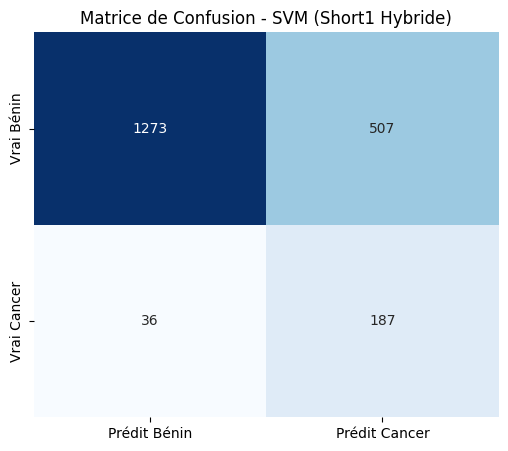

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

strict_weights = {0: 1, 1: 10}

# 1. Création du Pipeline (Nettoyage automatique + SVM)
# On utilise un noyau RBF (Radial Basis Function) comme suggéré dans la littérature (ex: Javaid et al.)
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0,class_weight=strict_weights, random_state=42))

# 2. Entraînement (C'est ici qu'il apprend)
print(" Entraînement du SVM en cours...")
svm_model.fit(X_train, y_train)

# 3. Prédiction (L'examen)
print(" Passage de l'examen (Prédiction sur le Test Set)...")
y_pred_svm = svm_model.predict(X_test)

# 4. Résultats
acc = accuracy_score(y_test, y_pred_svm)
print(f"\n Précision Globale (Accuracy) : {acc*100:.2f}%")

print("\n--- Rapport Détaillé ---")
print(classification_report(y_test, y_pred_svm, target_names=['Nævus (Bénin)', 'Mélanome (Cancer)']))

# 5. Matrice de Confusion Visuelle
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion - SVM (Short1 Hybride)')
plt.show()

🌲 Entraînement du Random Forest en cours...

🏆 Précision Globale (Random Forest) : 89.37%

--- Rapport Détaillé ---
                   precision    recall  f1-score   support

    Nævus (Bénin)       0.90      0.99      0.94      1780
Mélanome (Cancer)       0.64      0.10      0.18       223

         accuracy                           0.89      2003
        macro avg       0.77      0.55      0.56      2003
     weighted avg       0.87      0.89      0.86      2003



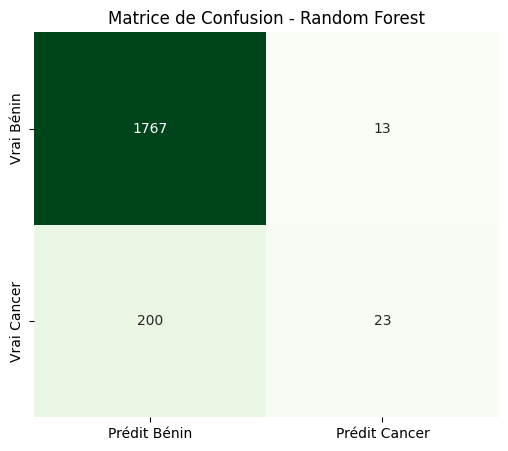

In [22]:
from sklearn.ensemble import RandomForestClassifier

print("🌲 Entraînement du Random Forest en cours...")

strict_weights = {0: 1, 1: 100}

# 1. Pipeline (Même nettoyage, mais classifieur plus malin)
# n_estimators=100 : On crée une forêt de 100 arbres de décision
rf_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100,class_weight=strict_weights, random_state=42))

# 2. Entraînement
rf_model.fit(X_train, y_train)

# 3. Prédiction
y_pred_rf = rf_model.predict(X_test)

# 4. Résultats
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\n🏆 Précision Globale (Random Forest) : {acc_rf*100:.2f}%")

print("\n--- Rapport Détaillé ---")
print(classification_report(y_test, y_pred_rf, target_names=['Nævus (Bénin)', 'Mélanome (Cancer)']))

# 5. Matrice de Confusion Comparée
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion - Random Forest')
plt.show()

🚀 Entraînement XGBoost (Ratio déséquilibre: 8.00)...
📝 Verdict XGBoost...
Accuracy : 83.62%

--- RAPPORT DÉTAILLÉ ---
              precision    recall  f1-score   support

       Bénin       0.94      0.87      0.90      1780
    Mélanome       0.35      0.53      0.42       223

    accuracy                           0.84      2003
   macro avg       0.64      0.70      0.66      2003
weighted avg       0.87      0.84      0.85      2003



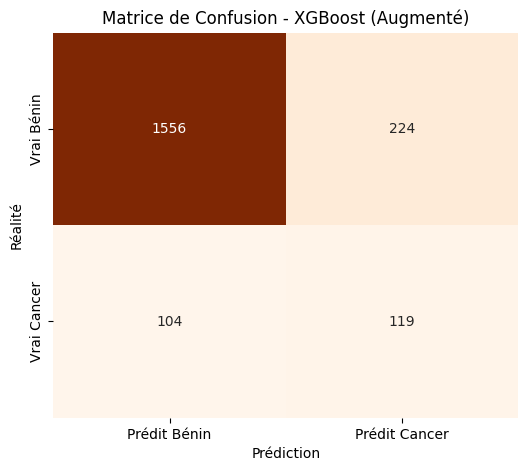

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. Calcul du ratio pour l'équilibre (Crucial pour XGBoost)
# ratio = (Nombre Bénins / Nombre Mélanomes)
# Si tu as beaucoup plus de bénins, ce chiffre sera > 1 et forcera le modèle à faire attention aux cancers.
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

print(f"🚀 Entraînement XGBoost (Ratio déséquilibre: {ratio:.2f})...")

# 2. Configuration du Modèle
model_xgb = XGBClassifier(
    n_estimators=300,        # Nombre d'arbres
    learning_rate=0.05,      # Vitesse d'apprentissage (plus petit = plus précis)
    max_depth=6,             # Profondeur max (évite l'overfitting)
    scale_pos_weight=ratio,  # LA clé pour gérer le déséquilibre
    # use_label_encoder=False,  <-- SUPPRIMÉ car obsolète
    eval_metric='logloss',
    random_state=42
)

# 3. Entraînement
model_xgb.fit(X_train, y_train)

print("📝 Verdict XGBoost...")
y_pred_xgb = model_xgb.predict(X_test)

# 4. Affichage des Scores
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb)*100:.2f}%")
print("\n--- RAPPORT DÉTAILLÉ ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Bénin', 'Mélanome']))

# 5. Matrice de Confusion (Visuelle)
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion - XGBoost (Augmenté)')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

🕵️‍♂️ Recherche des meilleurs hyperparamètres (GridSearch)...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1; total time= 1.1min
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1; total time= 1.1min
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1; total time= 1.1min
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.1; total time=  50.1s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.1; total time=  50.1s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.1; total time=  48.5s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.01; total time=  54.4s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.01; total time=  55.2s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.01; total time=  54.2s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.001; total time= 1.0min
[CV] END svc__C=0.1, svc__class_weigh

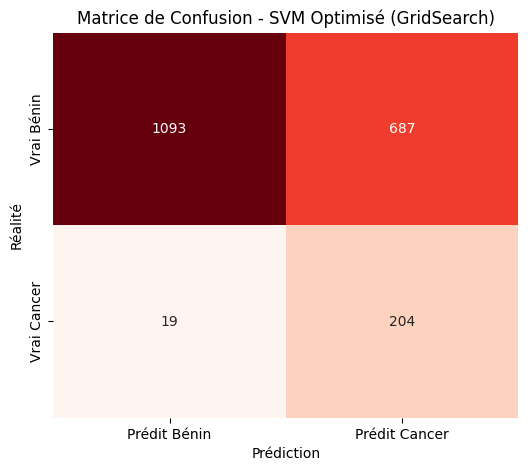

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. On définit la grille de recherche
param_grid = {
    'svc__C': [0.1, 1, 10, 50, 100],      # La "dureté" de la frontière
    'svc__gamma': [1, 0.1, 0.01, 0.001],  # La "portée" de chaque point
    'svc__class_weight': ['balanced', {0:1, 1:5}, {0:1, 1:10}] # Tester différents poids
}

# 2. On reprend votre pipeline
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))

print("🕵️‍♂️ Recherche des meilleurs hyperparamètres (GridSearch)...")
# Note : scoring='recall' force le modèle à privilégier la détection du cancer !
grid = GridSearchCV(pipeline, param_grid, refit=True, verbose=2, cv=3, scoring='recall') 

grid.fit(X_train, y_train)

print(f"\n🏆 Meilleurs paramètres trouvés : {grid.best_params_}")
print(f"🚀 Meilleur score Recall (Validation) : {grid.best_score_:.2f}")


# 3. Test sur le vrai Test Set avec le meilleur modèle
print("\n Test sur le vrai Test Set avec le meilleur modèle :")
y_pred_grid = grid.predict(X_test)
print(classification_report(y_test, y_pred_grid, target_names=['Bénin', 'Mélanome']))

# 4. AJOUT : Matrice de Confusion Visuelle
cm = confusion_matrix(y_test, y_pred_grid)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion - SVM Optimisé (GridSearch)')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

⚖️ Entraînement du Voting Classifier (Alliance SVM + RF)...

--- RAPPORT DÉTAILLÉ (Voting) ---
              precision    recall  f1-score   support

       Bénin       0.92      0.95      0.93      1780
    Mélanome       0.44      0.33      0.38       223

    accuracy                           0.88      2003
   macro avg       0.68      0.64      0.65      2003
weighted avg       0.86      0.88      0.87      2003



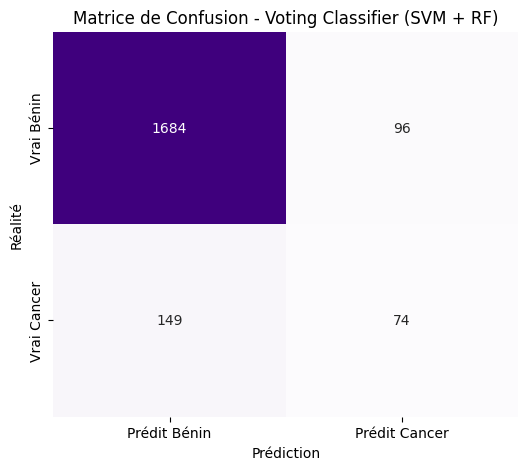

In [25]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. On recrée les deux modèles (Experts)
# SVM : Expert en frontières complexes (Géométrique)
svm_clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, class_weight='balanced', probability=True, random_state=42))

# Random Forest : Expert en décision hiérarchique (Logique)
rf_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, random_state=42)

# 2. Le Mariage (Voting Classifier)
voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('rf', rf_clf)],
    voting='soft' # 'soft' utilise la moyenne des probabilités (plus nuancé que le vote dur)
)

print("⚖️ Entraînement du Voting Classifier (Alliance SVM + RF)...")
voting_clf.fit(X_train, y_train)

# 3. Verdict
y_pred_vote = voting_clf.predict(X_test)

print("\n--- RAPPORT DÉTAILLÉ (Voting) ---")
print(classification_report(y_test, y_pred_vote, target_names=['Bénin', 'Mélanome']))

# 4. Matrice de Confusion Visuelle
cm = confusion_matrix(y_test, y_pred_vote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion - Voting Classifier (SVM + RF)')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

Data found: 16 columns (Features).
Retraining Random Forest (Light Mode)...
Model retrained.

DIAGNOSTIC: FEATURE IMPORTANCE RANKING


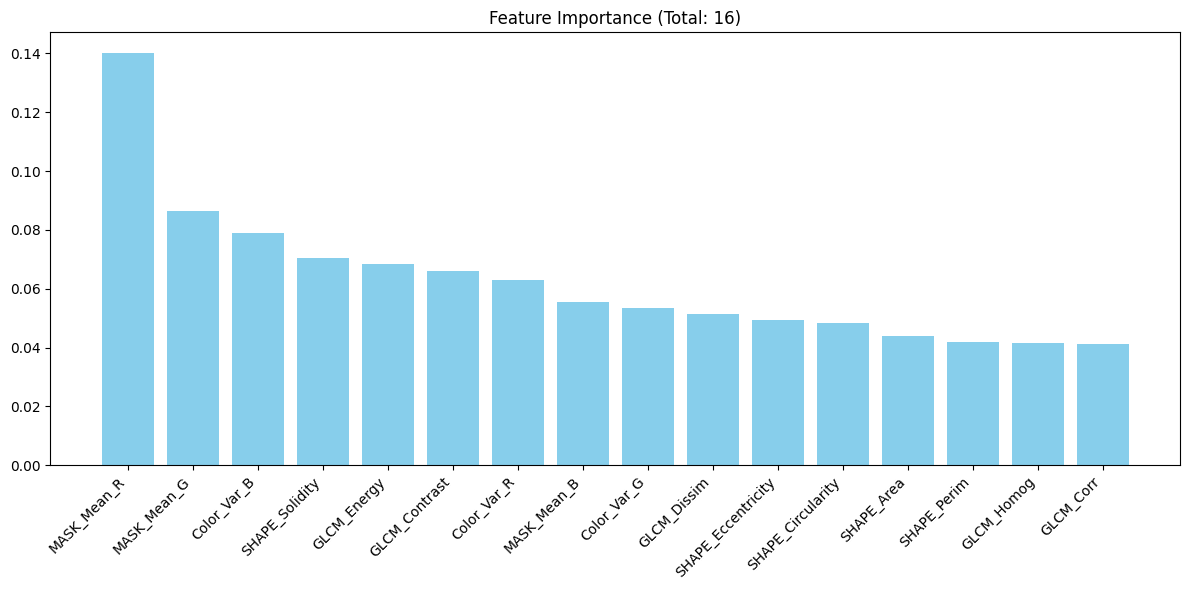


Ranking of ABCD Features:
  SHAPE_Area           : Rank #13  (Importance: 0.04408)
  SHAPE_Perim          : Rank #14  (Importance: 0.04200)
  SHAPE_Circularity    : Rank #12  (Importance: 0.04836)
  SHAPE_Eccentricity   : Rank #11  (Importance: 0.04935)
  SHAPE_Solidity       : Rank #4   (Importance: 0.07053)

Technical Audit:
Mean Area (SHAPE_Area): 9773.63
Area column contains data.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 1. SAFETY CHECK
if 'X_train' not in globals() or 'y_train' not in globals():
    print("ERROR: X_train and y_train do not exist.")
else:
    n_features = X_train.shape[1]
    print(f"Data found: {n_features} columns (Features).")

    # 2. IMMEDIATE RETRAINING
    print("Retraining Random Forest (Light Mode)...")
    rf_hybrid = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    rf_hybrid.fit(X_train, y_train)
    print("Model retrained.")

    # 3. RECONSTRUCTING FEATURE NAMES (For the 16 features)
    feat_names = []
    # A. Texture (GLCM) - 5
    feat_names += ['GLCM_Contrast', 'GLCM_Dissim', 'GLCM_Homog', 'GLCM_Energy', 'GLCM_Corr']
    # B. Color (Variegation) - 3
    feat_names += ['Color_Var_R', 'Color_Var_G', 'Color_Var_B']
    # C. Shape (ABCD) - 5
    feat_names += ['SHAPE_Area', 'SHAPE_Perim', 'SHAPE_Circularity', 'SHAPE_Eccentricity', 'SHAPE_Solidity']
    # D. Mask Color - 3
    feat_names += ['MASK_Mean_B', 'MASK_Mean_G', 'MASK_Mean_R']

    # Safety check for names length
    if len(feat_names) != n_features:
        print(f"Warning: Name list has {len(feat_names)} names but data has {n_features} columns.")
        # Fallback if sizes don't match to prevent crash
        feat_names = [f"Feat_{i}" for i in range(n_features)]

    # 4. IMPORTANCE CHART
    importances = rf_hybrid.named_steps['randomforestclassifier'].feature_importances_
    indices = np.argsort(importances)[::-1] # Sort descending

    # Adapt plot to number of features (use min to avoid index error)
    n_plot = min(20, n_features)
    
    print("\nDIAGNOSTIC: FEATURE IMPORTANCE RANKING")
    
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance (Total: {n_features})")
    plt.bar(range(n_plot), importances[indices[:n_plot]], align="center", color='skyblue')
    plt.xticks(range(n_plot), [feat_names[i] for i in indices[:n_plot]], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 5. TEXT VERDICT (ABCD Specifics)
    print("\nRanking of ABCD Features:")
    targets = ['SHAPE_Area', 'SHAPE_Perim', 'SHAPE_Circularity', 'SHAPE_Eccentricity', 'SHAPE_Solidity']
    
    for name in targets:
        if name in feat_names:
            real_idx = feat_names.index(name)
            # Find rank
            rank = list(indices).index(real_idx) + 1
            score = importances[real_idx]
            print(f"  {name:<20} : Rank #{rank:<3} (Importance: {score:.5f})")
        else:
            print(f"  {name} not found in the list.")

    # 6. Technical Audit
    print("\nTechnical Audit:")
    shape_cols = X_train[:, -8:-3] # Assuming Shape columns are still at this relative position
    print(f"Mean Area (SHAPE_Area): {shape_cols[:, 0].mean():.2f}")
    if shape_cols[:, 0].mean() == 0:
        print("ALERT: Area column is empty (0.0). Segmentation failed.")
    else:
        print("Area column contains data.")

🔄 Démarrage de SMOTE sur le Train Set (8000 images)...
Distribution AVANT SMOTE : Counter({np.int64(0): 21366, np.int64(1): 2670})
Distribution APRÈS SMOTE : Counter({np.int64(0): 21366, np.int64(1): 21366})
📈 Cancers synthétiques créés : +18696

🌲 Entraînement du Random Forest...
📝 Passage de l'examen...

🏆 PRÉCISION FINALE (SMOTE) : 85.27%

--- RAPPORT DÉTAILLÉ ---
              precision    recall  f1-score   support

       Bénin       0.93      0.90      0.92      1780
    Mélanome       0.38      0.48      0.42       223

    accuracy                           0.85      2003
   macro avg       0.65      0.69      0.67      2003
weighted avg       0.87      0.85      0.86      2003



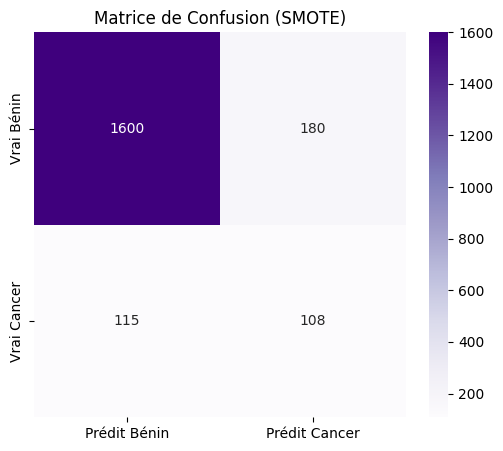

In [27]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("🔄 Démarrage de SMOTE sur le Train Set (8000 images)...")

# 1. Vérification de la situation actuelle
# On utilise X_train_full (votre dataset de 8000 images)
print(f"Distribution AVANT SMOTE : {Counter(y_train)}")
# Vous devriez voir environ : {0: 7110, 1: 890}

# 2. Application de SMOTE
# 'auto' dit à SMOTE : "Monte la classe minoritaire (1) au niveau de la majoritaire (0)"
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Distribution APRÈS SMOTE : {Counter(y_train_smote)}")
# Vous devriez voir : {0: 7110, 1: 7110} (Egalité parfaite)

gain = len(X_train_smote) - len(X_train)
print(f"📈 Cancers synthétiques créés : +{gain}")

# 3. Entraînement sur ce dataset massif (14 000+ exemples)
print(f"\n🌲 Entraînement du Random Forest...")

# Note : On enlève "class_weight='balanced'" car les données sont maintenant physiquement équilibrées
rf_smote = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(
        n_estimators=200, 
        max_depth=20,       # On autorise des arbres profonds car on a beaucoup de données
        min_samples_leaf=2, # Petite sécurité anti-overfitting
        random_state=42,
        n_jobs=-1
    )
)

rf_smote.fit(X_train_smote, y_train_smote)

# 4. Verdict sur le Test Set (2000 images réelles)
print("📝 Passage de l'examen...")
y_pred_smote = rf_smote.predict(X_test)

acc = accuracy_score(y_test, y_pred_smote)
print(f"\n🏆 PRÉCISION FINALE (SMOTE) : {acc*100:.2f}%")

print("\n--- RAPPORT DÉTAILLÉ ---")
print(classification_report(y_test, y_pred_smote, target_names=['Bénin', 'Mélanome']))

# 5. Matrice de Confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', cmap='Purples',
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion (SMOTE)')
plt.show()

🔄 Démarrage de SMOTE pour SVM...
Distribution AVANT : Counter({np.int64(0): 21366, np.int64(1): 2670})
Distribution APRÈS : Counter({np.int64(0): 21366, np.int64(1): 21366})
📈 Dataset gonflé à 42732 images.

🐢 Entraînement du SVM sur 14 000+ images (Patience, c'est lent !)...
📝 Passage de l'examen...

🏆 PRÉCISION FINALE (SVM + SMOTE) : 77.63%

--- RAPPORT DÉTAILLÉ ---
              precision    recall  f1-score   support

       Bénin       0.97      0.77      0.86      1780
    Mélanome       0.31      0.79      0.44       223

    accuracy                           0.78      2003
   macro avg       0.64      0.78      0.65      2003
weighted avg       0.89      0.78      0.81      2003



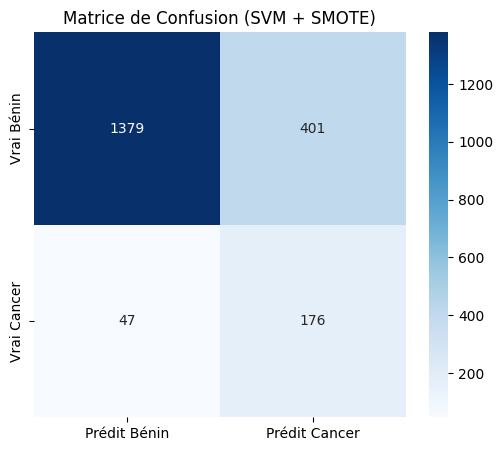

In [28]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("🔄 Démarrage de SMOTE pour SVM...")

# 1. Génération des données (C'est la même étape que pour le RF)
print(f"Distribution AVANT : {Counter(y_train)}")

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Distribution APRÈS : {Counter(y_train_smote)}")
print(f"📈 Dataset gonflé à {len(X_train_smote)} images.")

# 2. Entraînement du SVM
print(f"\n🐢 Entraînement du SVM sur 14 000+ images (Patience, c'est lent !)...")

# Note : On retire "class_weight='balanced'" car SMOTE a déjà équilibré les quantités.
# On garde le StandardScaler qui est OBLIGATOIRE pour le SVM.
svm_smote = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel='rbf',       # Le noyau standard pour les problèmes non-linéaires
        C=1.0,              # Pénalité standard
        probability=True,   # Activez ça si vous voulez faire du "Threshold Moving" plus tard
        random_state=42
        # Note : Pas de n_jobs pour SVM (il ne sait pas paralléliser l'entraînement d'un seul modèle)
    )
)

svm_smote.fit(X_train_smote, y_train_smote)

# 3. Verdict
print("📝 Passage de l'examen...")
y_pred_svm_smote = svm_smote.predict(X_test)

acc = accuracy_score(y_test, y_pred_svm_smote)
print(f"\n🏆 PRÉCISION FINALE (SVM + SMOTE) : {acc*100:.2f}%")

print("\n--- RAPPORT DÉTAILLÉ ---")
print(classification_report(y_test, y_pred_svm_smote, target_names=['Bénin', 'Mélanome']))

# 4. Matrice
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_smote), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion (SVM + SMOTE)')
plt.show()

🔄 Démarrage de SMOTE pour SVM...
Distribution AVANT : Counter({np.int64(0): 21366, np.int64(1): 2670})
Distribution APRÈS : Counter({np.int64(0): 21366, np.int64(1): 21366})
📈 Dataset gonflé à 42732 images.
🚀 Entraînement XGBoost (Ratio déséquilibre: 8.00)...
📝 Verdict XGBoost...
Accuracy : 72.99%

--- RAPPORT DÉTAILLÉ ---
              precision    recall  f1-score   support

       Bénin       0.96      0.73      0.83      1780
    Mélanome       0.26      0.76      0.38       223

    accuracy                           0.73      2003
   macro avg       0.61      0.74      0.61      2003
weighted avg       0.88      0.73      0.78      2003



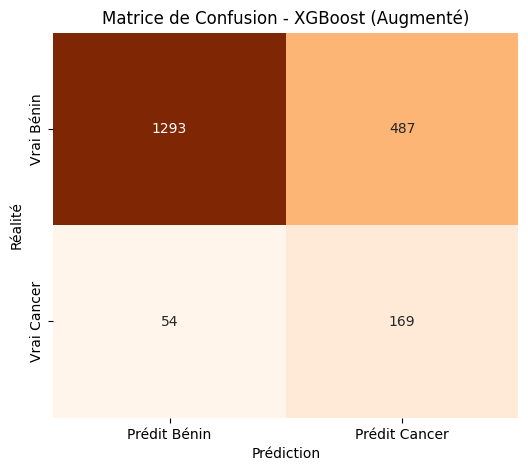

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


print("🔄 Démarrage de SMOTE pour SVM...")

# 1. Génération des données (C'est la même étape que pour le RF)
print(f"Distribution AVANT : {Counter(y_train)}")

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Distribution APRÈS : {Counter(y_train_smote)}")
print(f"📈 Dataset gonflé à {len(X_train_smote)} images.")

# 2. Calcul du ratio pour l'équilibre (Crucial pour XGBoost)
# ratio = (Nombre Bénins / Nombre Mélanomes)
# Si tu as beaucoup plus de bénins, ce chiffre sera > 1 et forcera le modèle à faire attention aux cancers.
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

print(f"🚀 Entraînement XGBoost (Ratio déséquilibre: {ratio:.2f})...")

# 2. Configuration du Modèle
model_xgb = XGBClassifier(
    n_estimators=300,        # Nombre d'arbres
    learning_rate=0.05,      # Vitesse d'apprentissage (plus petit = plus précis)
    max_depth=6,             # Profondeur max (évite l'overfitting)
    scale_pos_weight=ratio,  # LA clé pour gérer le déséquilibre
    # use_label_encoder=False,  <-- SUPPRIMÉ car obsolète
    eval_metric='logloss',
    random_state=42
)

# 3. Entraînement
model_xgb.fit(X_train_smote, y_train_smote)

print("📝 Verdict XGBoost...")
y_pred_xgb = model_xgb.predict(X_test)

# 4. Affichage des Scores
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb)*100:.2f}%")
print("\n--- RAPPORT DÉTAILLÉ ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Bénin', 'Mélanome']))

# 5. Matrice de Confusion (Visuelle)
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Prédit Bénin', 'Prédit Cancer'],
            yticklabels=['Vrai Bénin', 'Vrai Cancer'])
plt.title('Matrice de Confusion - XGBoost (Augmenté)')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

ANALYZING BEST FEATURES...

TOP 20 FEATURES:
   #1 : MASK_Mean_R (Score: 0.1388)
   #2 : MASK_Mean_G (Score: 0.0857)
   #3 : Color_Var_B (Score: 0.0811)
   #4 : SHAPE_Solidity (Score: 0.0734)
   #5 : GLCM_Energy (Score: 0.0685)
   #6 : GLCM_Contrast (Score: 0.0659)
   #7 : Color_Var_R (Score: 0.0629)
   #8 : MASK_Mean_B (Score: 0.0553)
   #9 : GLCM_Dissim (Score: 0.0512)
   #10 : Color_Var_G (Score: 0.0510)
   #11 : SHAPE_Eccentricity (Score: 0.0490)
   #12 : SHAPE_Circularity (Score: 0.0474)
   #13 : SHAPE_Area (Score: 0.0445)
   #14 : GLCM_Corr (Score: 0.0426)
   #15 : GLCM_Homog (Score: 0.0414)
   #16 : SHAPE_Perim (Score: 0.0412)

RANKING OF SHAPE (ABCD) FEATURES:
   SHAPE_Area           : Rank #13 (Importance: 0.0445)
   SHAPE_Perim          : Rank #16 (Importance: 0.0412)
   SHAPE_Circularity    : Rank #12 (Importance: 0.0474)
   SHAPE_Eccentricity   : Rank #11 (Importance: 0.0490)
   SHAPE_Solidity       : Rank #4 (Importance: 0.0734)

CREATING ELITE DATASET (TOP 50)...
Reductio

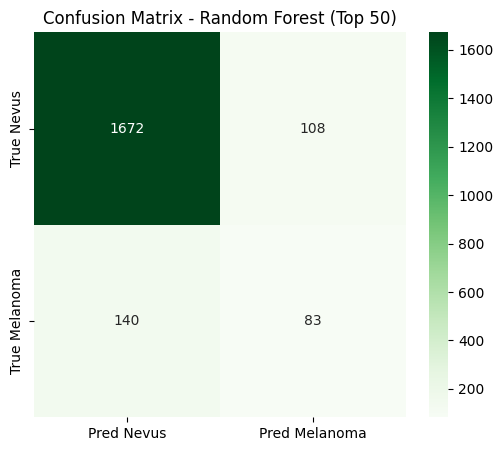


Training SVM (On Top 50)...
SVM Accuracy : 74.59%
              precision    recall  f1-score   support

       Nevus       0.97      0.74      0.84      1780
    Melanoma       0.28      0.83      0.42       223

    accuracy                           0.75      2003
   macro avg       0.63      0.78      0.63      2003
weighted avg       0.89      0.75      0.79      2003



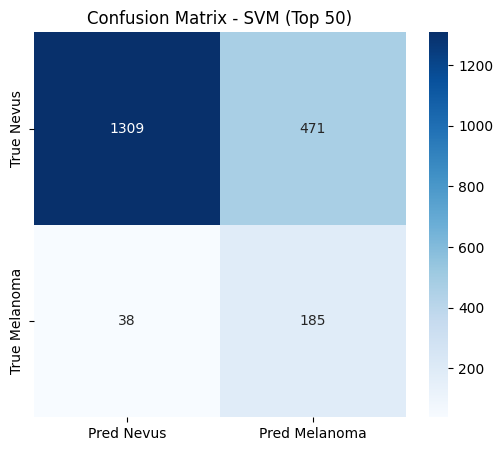

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("ANALYZING BEST FEATURES...")

# 1. Reconstruct feature names to identify them
# Order: GLCM (5) -> ColorVar (3) -> LBP (256) -> Shape (5) -> MaskColor (3)
feat_names = []
feat_names += ['GLCM_Contrast', 'GLCM_Dissim', 'GLCM_Homog', 'GLCM_Energy', 'GLCM_Corr']
feat_names += ['Color_Var_R', 'Color_Var_G', 'Color_Var_B']
feat_names += ['SHAPE_Area', 'SHAPE_Perim', 'SHAPE_Circularity', 'SHAPE_Eccentricity', 'SHAPE_Solidity']
feat_names += ['MASK_Mean_B', 'MASK_Mean_G', 'MASK_Mean_R']

# 2. Use Random Forest to grade the features (on Full Dataset)
rf_selector = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

# Get scores
importances = rf_selector.feature_importances_
indices = np.argsort(importances)[::-1] # Sort descending

# 3. Print the Top 20 Features
print("\nTOP 20 FEATURES:")
for i in range(16):
    idx = indices[i]
    print(f"   #{i+1} : {feat_names[idx]} (Score: {importances[idx]:.4f})")

# Check specifically for Shape features (ABCD)
print("\nRANKING OF SHAPE (ABCD) FEATURES:")
abcd_vars = ['SHAPE_Area', 'SHAPE_Perim', 'SHAPE_Circularity', 'SHAPE_Eccentricity', 'SHAPE_Solidity']
for name in abcd_vars:
    try:
        real_idx = feat_names.index(name)
        rank = list(indices).index(real_idx) + 1
        print(f"   {name:<20} : Rank #{rank} (Importance: {importances[real_idx]:.4f})")
    except: pass

# ====================================================
# PHASE 2: CREATE ELITE DATASET (TOP 50)
# ====================================================
print("\nCREATING ELITE DATASET (TOP 50)...")

# Keep only the 50 best columns
selector = SelectFromModel(rf_selector, max_features=50, threshold=-np.inf, prefit=True)

X_train_elite = selector.transform(X_train)
X_test_elite = selector.transform(X_test)

print(f"Reduction : {X_train.shape[1]} features -> {X_train_elite.shape[1]} features")

# ====================================================
# PHASE 3: RETRAINING ON ELITE FEATURES
# ====================================================

# A. RANDOM FOREST ELITE
print("\nTraining Random Forest (On Top 50)...")
rf_elite = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=15, random_state=42, n_jobs=-1)
)
rf_elite.fit(X_train_elite, y_train)
y_pred_rf = rf_elite.predict(X_test_elite)

print(f"RF Accuracy : {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(classification_report(y_test, y_pred_rf, target_names=['Nevus', 'Melanoma']))

# --- CONFUSION MATRIX RANDOM FOREST ---
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Nevus', 'Pred Melanoma'],
            yticklabels=['True Nevus', 'True Melanoma'])
plt.title('Confusion Matrix - Random Forest (Top 50)')
plt.show()


# B. SVM ELITE
print("\nTraining SVM (On Top 50)...")
svm_elite = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', class_weight='balanced', C=1.0, probability=True, random_state=42)
)
svm_elite.fit(X_train_elite, y_train)
y_pred_svm = svm_elite.predict(X_test_elite)

print(f"SVM Accuracy : {accuracy_score(y_test, y_pred_svm)*100:.2f}%")
print(classification_report(y_test, y_pred_svm, target_names=['Nevus', 'Melanoma']))

# --- CONFUSION MATRIX SVM ---
plt.figure(figsize=(6, 5))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Nevus', 'Pred Melanoma'],
            yticklabels=['True Nevus', 'True Melanoma'])
plt.title('Confusion Matrix - SVM (Top 50)')
plt.show()

ANALYZING BEST FEATURES...

TOP 20 FEATURES:
   #1 : MASK_Mean_R (Score: 0.1388)
   #2 : MASK_Mean_G (Score: 0.0857)
   #3 : Color_Var_B (Score: 0.0811)
   #4 : SHAPE_Solidity (Score: 0.0734)
   #5 : GLCM_Energy (Score: 0.0685)
   #6 : GLCM_Contrast (Score: 0.0659)
   #7 : Color_Var_R (Score: 0.0629)
   #8 : MASK_Mean_B (Score: 0.0553)
   #9 : GLCM_Dissim (Score: 0.0512)
   #10 : Color_Var_G (Score: 0.0510)

RANKING OF SHAPE (ABCD) FEATURES:
   SHAPE_Area           : Rank #13 (Importance: 0.0445)
   SHAPE_Perim          : Rank #16 (Importance: 0.0412)
   SHAPE_Circularity    : Rank #12 (Importance: 0.0474)
   SHAPE_Eccentricity   : Rank #11 (Importance: 0.0490)
   SHAPE_Solidity       : Rank #4 (Importance: 0.0734)

CREATING ELITE DATASET (TOP 20)...
Reduction : 16 features -> 16 features

Training Random Forest (On Top 20)...
RF Accuracy : 87.62%
              precision    recall  f1-score   support

       Nevus       0.92      0.94      0.93      1780
    Melanoma       0.43      0.

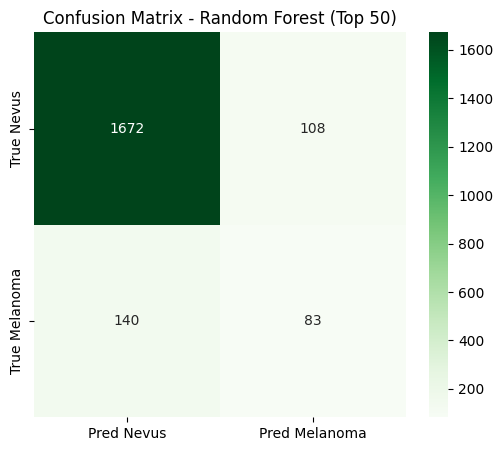


Training SVM (On Top 50)...
SVM Accuracy : 74.59%
              precision    recall  f1-score   support

       Nevus       0.97      0.74      0.84      1780
    Melanoma       0.28      0.83      0.42       223

    accuracy                           0.75      2003
   macro avg       0.63      0.78      0.63      2003
weighted avg       0.89      0.75      0.79      2003



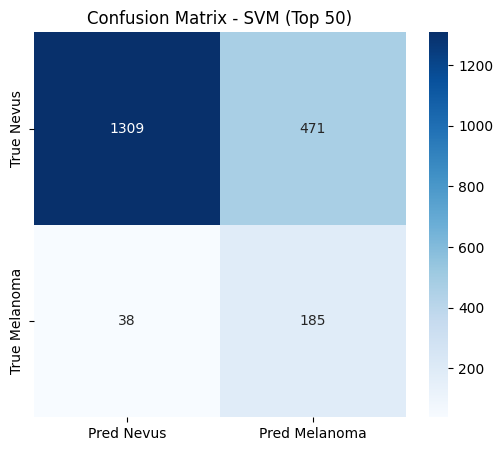

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("ANALYZING BEST FEATURES...")

# 1. Reconstruct feature names to identify them
# Order: GLCM (5) -> ColorVar (3) -> LBP (256) -> Shape (5) -> MaskColor (3)
feat_names = []
feat_names += ['GLCM_Contrast', 'GLCM_Dissim', 'GLCM_Homog', 'GLCM_Energy', 'GLCM_Corr']
feat_names += ['Color_Var_R', 'Color_Var_G', 'Color_Var_B']
feat_names += ['SHAPE_Area', 'SHAPE_Perim', 'SHAPE_Circularity', 'SHAPE_Eccentricity', 'SHAPE_Solidity']
feat_names += ['MASK_Mean_B', 'MASK_Mean_G', 'MASK_Mean_R']

# 2. Use Random Forest to grade the features (on Full Dataset)
rf_selector = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

# Get scores
importances = rf_selector.feature_importances_
indices = np.argsort(importances)[::-1] # Sort descending

# 3. Print the Top 20 Features
print("\nTOP 20 FEATURES:")
for i in range(10):
    idx = indices[i]
    print(f"   #{i+1} : {feat_names[idx]} (Score: {importances[idx]:.4f})")

# Check specifically for Shape features (ABCD)
print("\nRANKING OF SHAPE (ABCD) FEATURES:")
abcd_vars = ['SHAPE_Area', 'SHAPE_Perim', 'SHAPE_Circularity', 'SHAPE_Eccentricity', 'SHAPE_Solidity']
for name in abcd_vars:
    try:
        real_idx = feat_names.index(name)
        rank = list(indices).index(real_idx) + 1
        print(f"   {name:<20} : Rank #{rank} (Importance: {importances[real_idx]:.4f})")
    except: pass

# ====================================================
# PHASE 2: CREATE ELITE DATASET (TOP 20)
# ====================================================
print("\nCREATING ELITE DATASET (TOP 20)...")

# Keep only the 30 best columns
selector = SelectFromModel(rf_selector, max_features=20, threshold=-np.inf, prefit=True)

X_train_elite = selector.transform(X_train)
X_test_elite = selector.transform(X_test)

print(f"Reduction : {X_train.shape[1]} features -> {X_train_elite.shape[1]} features")

# ====================================================
# PHASE 3: RETRAINING ON ELITE FEATURES
# ====================================================

# A. RANDOM FOREST ELITE
print("\nTraining Random Forest (On Top 20)...")
rf_elite = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=15, random_state=42, n_jobs=-1)
)
rf_elite.fit(X_train_elite, y_train)
y_pred_rf = rf_elite.predict(X_test_elite)

print(f"RF Accuracy : {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(classification_report(y_test, y_pred_rf, target_names=['Nevus', 'Melanoma']))

# --- CONFUSION MATRIX RANDOM FOREST ---
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Nevus', 'Pred Melanoma'],
            yticklabels=['True Nevus', 'True Melanoma'])
plt.title('Confusion Matrix - Random Forest (Top 50)')
plt.show()


# B. SVM ELITE
print("\nTraining SVM (On Top 50)...")
svm_elite = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', class_weight='balanced', C=1.0, probability=True, random_state=42)
)
svm_elite.fit(X_train_elite, y_train)
y_pred_svm = svm_elite.predict(X_test_elite)

print(f"SVM Accuracy : {accuracy_score(y_test, y_pred_svm)*100:.2f}%")
print(classification_report(y_test, y_pred_svm, target_names=['Nevus', 'Melanoma']))

# --- CONFUSION MATRIX SVM ---
plt.figure(figsize=(6, 5))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Nevus', 'Pred Melanoma'],
            yticklabels=['True Nevus', 'True Melanoma'])
plt.title('Confusion Matrix - SVM (Top 50)')
plt.show()